# =================== CV2 Table Edge detection ===================

In [11]:
import os

def delete_files_in_directory(directory_path):
   try:
     files = os.listdir(directory_path)
     for file in files:
       file_path = os.path.join(directory_path, file)
       if os.path.isfile(file_path):
         os.remove(file_path)
     print("All files deleted successfully.")
   except OSError:
     print("Error occurred while deleting files.")


All files deleted successfully.
All files deleted successfully.
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


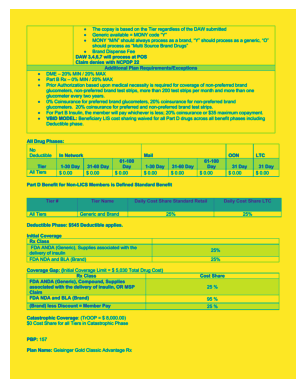

In [26]:
import cv2
import numpy as np  
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
import numpy as np
from PIL import Image, ImageOps
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures, Direction, DirectionalFinderType
img_path = "/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/img_data/pdf_out/page3.jpg"
out_path = "/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/cv2_out/"
out_sub_tables = "/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/out_tables/"

#------------ Deleting files from out_path and out_sub_tables ------------
delete_files_in_directory(out_path)
delete_files_in_directory(out_sub_tables)

# Read the image
img = cv2.imread(img_path, 0)
print(img)
plt.imshow(img)
#Thresholding the image
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|     cv2.THRESH_OTSU)
# Invert the image
img_bin = 255-img_bin 
cv2.imwrite(out_path+"1.Image_bin.jpg",img_bin)
#plt.imshow(cv2.cvtColor(img_bin, cv2.COLOR_BAYER_GR2GRAY))

plt.axis('off')
plt.show()

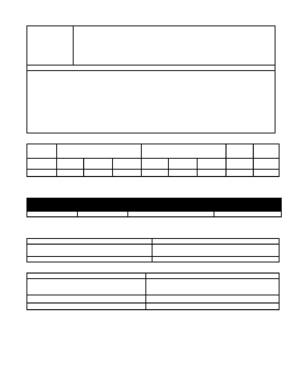

In [27]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//80
 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
cv2.imwrite(out_path+"2.verticle_lines.jpg",verticle_lines_img)
#plt.imshow(verticle_lines_img)
# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)

horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
cv2.imwrite(out_path+"3.horizontal_lines.jpg",horizontal_lines_img)
#plt.imshow(horizontal_lines_img)

# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite(out_path+"4.img_final_bin.jpg",img_final_bin)
plt.imshow(cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

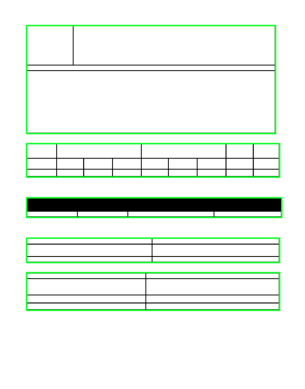

In [28]:
img_final_bin = cv2.imread("/Users/user/Documents/Project/___e-zest___/Detecting-and-Parsing-table-from-pdfs/1.using_cv2/cv2_out/4.img_final_bin.jpg")
original = img_final_bin.copy()
gray = cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(img_final_bin, (x, y), (x + w, y + h), (36,255,12), 7)
    ROI = img[y:y+h, x:x+w]
    cv2.imwrite(out_sub_tables+'Table_{}.png'.format(ROI_number), ROI)
    ROI_number += 1

cv2.imwrite(out_path+"5.img_table_detect.jpg",img_final_bin)
plt.imshow(cv2.cvtColor(img_final_bin, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [42]:
extractor = Textractor(profile_name="default")
try:
    document = extractor.analyze_document(
        file_source=out_sub_tables+"Table_3.png",
        features=[TextractFeatures.TABLES],
        save_image=True
    )
    table = EntityList(document.tables[0])
    document.tables[0].visualize()
except Exception as e:
    print("Error: {}".format(e))



Error: font size must be greater than 0, not 0


In [43]:
#table[0].to_excel(filepath="data/out.xlsx")
table[0].to_pandas()

,0,1,2,3,4,5,6,7,8
0,[X] No Deductible,In Network,,,Mail,,,OON,LTC
1,Tier,1-30 Day,31-60 Day,61-100 Day,1-30 Day,31-60 Day,61-100 Day,31 Day,31 Day
2,All Tiers,$ 0.00,$ 0.00,$ 0.00,$ 0.00,$ 0.00,$ 0.00,$ 0.00,$ 0.00


# =================================================================================